Entrez la valeur de M pour M-QAM (ex: 4, 16, 64, 256):  64


Modulation choisie : 64-QAM → 6 bits par symbole


Voulez-vous utiliser le codage Gray ? (y/n) :  y
Entrez la position I du premier symbole (ex: -3, -1, 1, 3):  1
Entrez la position Q du premier symbole (ex: -3, -1, 1, 3):  1
Type de bruit ? (1: phase, 2: amplitude, 3: combiné) :  1
Nombre de versions bruitées à générer :  16


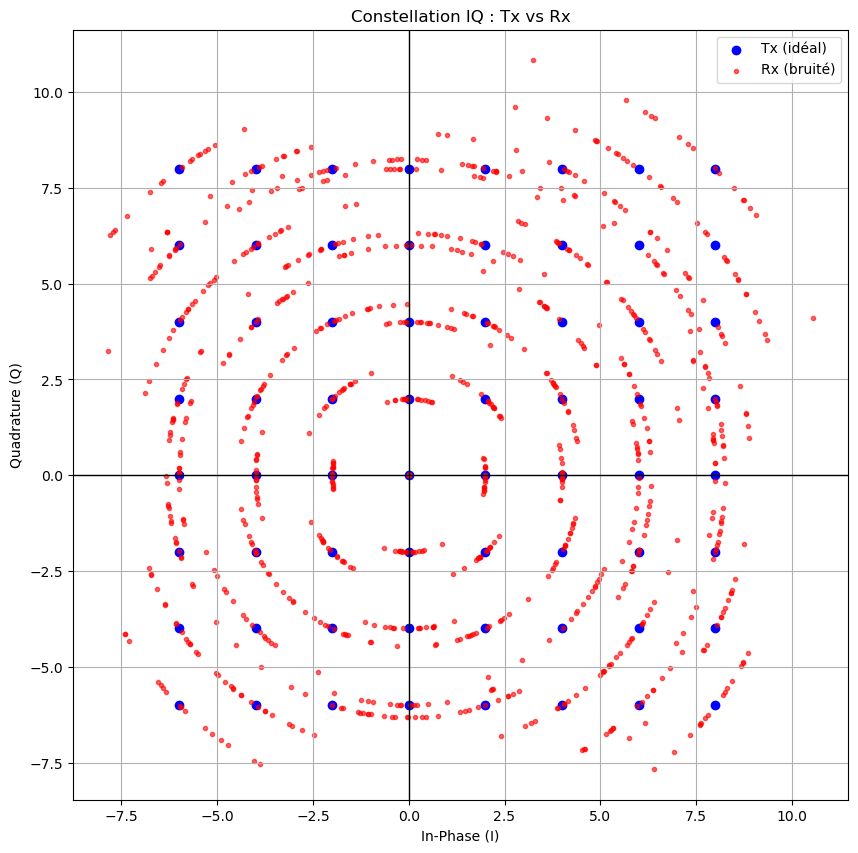


SNR calculé : 15.07 dB

--- Table de correspondance QAM ---
Symbole   Bits  Décimal  I  Q  Amplitude  Énergie  Phase (rad)
     S0 000000        0 -7  7       9.90       98       2.3562
     S1 000001        1 -5  7       8.60       74       2.1910
     S2 000011        2 -3  7       7.62       58       1.9757
     S3 000010        3 -1  7       7.07       50       1.7127
     S4 000110        4  1  7       7.07       50       1.4289
     S5 000111        5  3  7       7.62       58       1.1659
     S6 000101        6  5  7       8.60       74       0.9505
     S7 000100        7  7  7       9.90       98       0.7854
     S8 001100        8 -7  5       8.60       74       2.5213
     S9 001101        9 -5  5       7.07       50       2.3562
    S10 001111       10 -3  5       5.83       34       2.1112
    S11 001110       11 -1  5       5.10       26       1.7682
    S12 001010       12  1  5       5.10       26       1.3734
    S13 001011       13  3  5       5.83       34       1

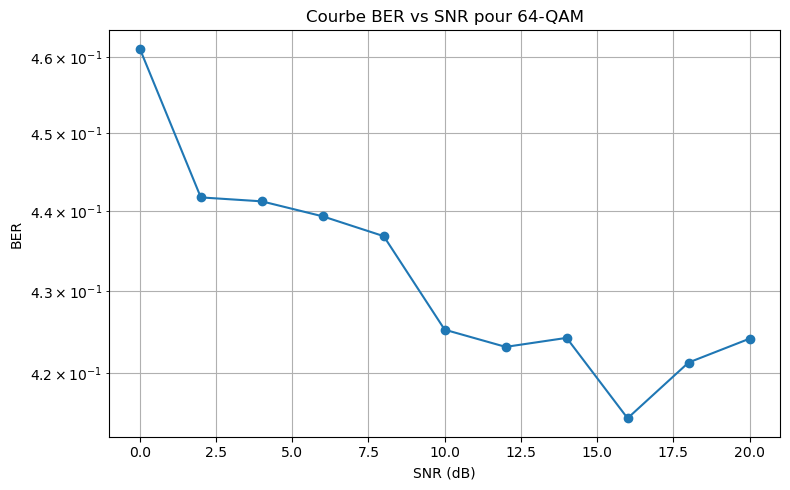

Simulation complète et exportations terminées.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# --- Étape 1 : Choix utilisateur pour M-QAM ---
def get_mqam_parameters():
    M = int(input("Entrez la valeur de M pour M-QAM (ex: 4, 16, 64, 256): "))
    if not (M != 0 and ((M & (M - 1)) == 0)):
        raise ValueError("M doit être une puissance de 2 (2, 4, 8, 16, ...)")
    k = int(np.log2(M))
    print(f"Modulation choisie : {M}-QAM → {k} bits par symbole")

    gray_choice = input("Voulez-vous utiliser le codage Gray ? (y/n) : ").strip().lower()
    use_gray = gray_choice == 'y'

    return M, k, use_gray

# --- Étape 2 : Génération du codage Gray ---
def generate_gray_code(n):
    if n == 1:
        return ['0', '1']
    prev_gray = generate_gray_code(n - 1)
    return ['0' + code for code in prev_gray] + ['1' + code for code in reversed(prev_gray)]

# --- Étape 3 : Génération de la table de correspondance QAM ---
def generate_qam_constellation(M, k, use_gray):
    side = int(np.sqrt(M))
    if side**2 != M:
        raise ValueError("M-QAM doit être un carré parfait (ex: 4, 16, 64...)")

    levels = np.arange(-side + 1, side, 2)
    iq_points = [(i, q) for q in reversed(levels) for i in levels]
    decimals = np.arange(M)
    bits_bin = [format(d, f'0{k}b') for d in decimals]

    if use_gray:
        gray_list = generate_gray_code(k)
        bits = gray_list
    else:
        bits = bits_bin

    table = []
    for idx in range(M):
        bits_str = bits[idx]
        dec = int(bits_bin[idx], 2)
        i, q = iq_points[idx]
        energy = i**2 + q**2
        amplitude = np.sqrt(energy)
        phase = np.arctan2(q, i)
        table.append({
            'Symbole': f"S{idx}",
            'Bits': bits_str,
            'Décimal': dec,
            'I': i,
            'Q': q,
            'Amplitude': round(amplitude, 2),
            'Énergie': round(energy, 2),
            'Phase (rad)': round(phase, 4)
        })

    return pd.DataFrame(table, columns=['Symbole', 'Bits', 'Décimal', 'I', 'Q', 'Amplitude', 'Énergie', 'Phase (rad)'])

# --- Étape 4 : Bilan des énergies et des phases ---
def bilan_energies_phases(df):
    energies = df['Énergie']
    phases_rad = df['Phase (rad)']

    energie_tot = np.sum(energies)
    energie_moy = np.mean(energies)
    energie_min = np.min(energies)
    energie_max = np.max(energies)
    energie_var = np.var(energies)

    print("\n--- Bilan des Énergies ---")
    print(f"Énergie totale : {energie_tot:.2f}")
    print(f"Énergie moyenne : {energie_moy:.2f}")
    print(f"Énergie min : {energie_min:.2f}")
    print(f"Énergie max : {energie_max:.2f}")
    print(f"Variance énergie : {energie_var:.2f}")

    unique_energies = sorted(df['Énergie'].unique())
    energie_distribution = []
    for e in unique_energies:
        sous_ensemble = df[df['Énergie'] == e]
        energie_distribution.append((e, sous_ensemble[['I', 'Q']].values.tolist()))
        print(f"\nPour l'énergie {e} → {len(sous_ensemble)} niveaux :")
        for _, row in sous_ensemble.iterrows():
            print(f"→ (I = {row['I']}, Q = {row['Q']})")

    phase_totale = len(phases_rad)
    unique_phases = np.unique(phases_rad)
    phase_min = np.min(phases_rad)
    phase_max = np.max(phases_rad)

    print("\n--- Bilan des Phases (radians) ---")
    print(f"Nombre total de phases : {phase_totale}")
    print(f"Nombre unique de phases : {len(unique_phases)}")
    print(f"Phase min : {phase_min:.4f} rad  ← phase de déclenchement")
    print(f"Phase max : {phase_max:.4f} rad")

    return energie_tot, energie_moy, energie_min, energie_max, energie_var, phase_min, phase_max, energie_distribution

# --- Étape 5 : Choix du point de départ ---
def choix_premier_point():
    I_0 = float(input("Entrez la position I du premier symbole (ex: -3, -1, 1, 3): "))
    Q_0 = float(input("Entrez la position Q du premier symbole (ex: -3, -1, 1, 3): "))
    return I_0, Q_0

# --- Génération de constellation personnalisée ---
def generate_custom_qam_constellation(M, I_0, Q_0):
    side = int(np.sqrt(M))
    levels = np.arange(side) * 2 - (side - 1)
    iq_points = [(i + I_0, q + Q_0) for q in reversed(levels) for i in levels]
    return np.array(iq_points)

# --- Ajout de bruit configurable ---
def add_noise(points, noise_type=1, num_noisy_points=1):
    noisy_all = []
    for _ in range(num_noisy_points):
        if noise_type == 1:
            noise_phase = np.random.randn(len(points)) * (np.pi / 18)
            noisy = points * np.exp(1j * noise_phase)
        elif noise_type == 2:
            amp_noise = np.random.randn(len(points)) * 0.2
            amplitude = np.abs(points) + amp_noise
            noisy = amplitude * np.exp(1j * np.angle(points))
        elif noise_type == 3:
            noise_phase = np.random.randn(len(points)) * (np.pi / 18)
            amp_noise = np.random.randn(len(points)) * 0.2
            amplitude = np.abs(points) + amp_noise
            noisy = amplitude * np.exp(1j * (np.angle(points) + noise_phase))
        else:
            raise ValueError("noise_type doit être 1 (phase), 2 (amplitude), ou 3 (combiné).")
        noisy_all.append(noisy)
    return np.concatenate(noisy_all)

# --- Calcul SNR ---
def calculate_snr(signal, noisy_signal):
    noise = noisy_signal - np.tile(signal, int(len(noisy_signal) / len(signal)))
    signal_power = np.mean(np.abs(signal)**2)
    noise_power = np.mean(np.abs(noise)**2)
    return 10 * np.log10(signal_power / noise_power)

# --- Calcul BER ---
def calculate_ber(original_bits, received_bits):
    errors = np.sum(original_bits != received_bits)
    return errors / len(original_bits)

# --- Détection des symboles ---
def detect_symbols(rx_points, ref_points, ref_bits):
    detected_bits = []
    for pt in rx_points:
        idx = np.argmin(np.abs(ref_points - pt))
        detected_bits.append(list(map(int, list(ref_bits[idx]))))
    return np.array(detected_bits)

# --- Visualisation constellation Tx vs Rx ---
def visualiser_constellation_comparée(tx_points, rx_points):
    plt.figure(figsize=(10, 10))
    plt.scatter(tx_points.real, tx_points.imag, color='blue', marker='o', label='Tx (idéal)')
    plt.scatter(rx_points.real, rx_points.imag, color='red', marker='.', alpha=0.6, label='Rx (bruité)')
    plt.title("Constellation IQ : Tx vs Rx")
    plt.xlabel("In-Phase (I)")
    plt.ylabel("Quadrature (Q)")
    plt.grid(True)
    plt.axhline(0, color='black', linewidth=1)
    plt.axvline(0, color='black', linewidth=1)
    plt.legend()
    plt.axis('equal')
    plt.show()

# --- MAIN ---
M, k, use_gray = get_mqam_parameters()
I_0, Q_0 = choix_premier_point()
iq_points = generate_custom_qam_constellation(M, I_0, Q_0)
iq_points_complex = iq_points[:, 0] + 1j * iq_points[:, 1]

noise_type = int(input("Type de bruit ? (1: phase, 2: amplitude, 3: combiné) : "))
num_noisy = int(input("Nombre de versions bruitées à générer : "))
noisy_iq_points = add_noise(iq_points_complex, noise_type=noise_type, num_noisy_points=num_noisy)

visualiser_constellation_comparée(iq_points_complex, noisy_iq_points)

calculated_snr = calculate_snr(iq_points_complex, noisy_iq_points)
print(f"\nSNR calculé : {calculated_snr:.2f} dB")

constellation_table = generate_qam_constellation(M, k, use_gray)
print("\n--- Table de correspondance QAM ---")
print(constellation_table.to_string(index=False))

bilan_energies_phases(constellation_table)

original_bits = np.array([list(map(int, list(format(i, f'0{k}b')))) for i in range(M)])
original_bits = np.tile(original_bits, (num_noisy, 1))

received_bits = detect_symbols(noisy_iq_points, iq_points_complex, constellation_table['Bits'].values)
if original_bits.shape == received_bits.shape:
    ber = calculate_ber(original_bits.flatten(), received_bits.flatten())
    print(f"\nBit Error Rate (BER) : {ber:.6f}")
else:
    print("Erreur : dimensions des bits Tx/Rx incompatibles pour le calcul du BER.")

# Export CSV
constellation_table.to_csv("constellation_qam.csv", index=False)
print("\nTable de correspondance exportée vers 'constellation_qam.csv'")

# Courbe BER vs SNR
snr_range_db = np.arange(0, 21, 2)
ber_values = []
num_bits = 10000
num_bits_adjusted = num_bits - (num_bits % k)

for snr_db in snr_range_db:
    bits_tx = np.random.randint(0, 2, num_bits_adjusted)
    symbols = bits_tx.reshape(-1, k)
    dec = np.array([int("".join(map(str, b)), 2) for b in symbols])
    tx_symbols = iq_points_complex[dec]

    snr_linear = 10**(snr_db / 10)
    noise_power = np.mean(np.abs(iq_points_complex)**2) / snr_linear
    noise = np.sqrt(noise_power / 2) * (np.random.randn(len(tx_symbols)) + 1j * np.random.randn(len(tx_symbols)))
    rx_symbols = tx_symbols + noise

    rx_bits = detect_symbols(rx_symbols, iq_points_complex, constellation_table['Bits'].values)
    bits_rx = rx_bits.flatten()[:num_bits_adjusted]
    ber = calculate_ber(bits_tx[:len(bits_rx)], bits_rx)
    ber_values.append(ber)

# Appel de la fonction bilan_energies_phases et capture des résultats
energie_tot, energie_moy, energie_min, energie_max, energie_var, phase_min, phase_max, energie_distribution = bilan_energies_phases(constellation_table)

# Export PDF
with PdfPages('simulation_qam.pdf') as pdf:
    # Page 1 : Courbe BER
    plt.figure(figsize=(8, 5))
    plt.semilogy(snr_range_db, ber_values, marker='o')
    plt.grid(True, which='both')
    plt.xlabel("SNR (dB)")
    plt.ylabel("BER")
    plt.title(f"Courbe BER vs SNR pour {M}-QAM")
    plt.tight_layout()
    pdf.savefig()
    plt.show()     # affiche la courbe à l’écran
    plt.close()

    # Page 2 : Bilan SNR et énergie/phase
    fig, ax = plt.subplots(figsize=(8.5, 11))
    ax.axis('off')
    ax.text(0, 1.0, f"SNR calculé : {calculated_snr:.2f} dB", fontsize=12)
    ax.text(0, 0.95, f"Bit Error Rate (BER) : {ber:.6f}", fontsize=12)
    ax.text(0, 0.91, f"--- Bilan des Énergies ---", fontsize=12)
    ax.text(0, 0.87, f"Énergie totale : {energie_tot:.2f}", fontsize=12)  # Utilisation de la variable correctement définie
    ax.text(0, 0.83, f"Énergie moyenne : {energie_moy:.2f}", fontsize=12)
    ax.text(0, 0.79, f"Énergie min : {energie_min:.2f}", fontsize=12)
    ax.text(0, 0.75, f"Énergie max : {energie_max:.2f}", fontsize=12)
    ax.text(0, 0.71, f"Variance énergie : {energie_var:.2f}", fontsize=12)
    ax.text(0, 0.67, f"--- Bilan des Phases ---", fontsize=12)
    ax.text(0, 0.63, f"Phase min : {phase_min:.4f} rad  ← phase de déclenchement", fontsize=12)
    ax.text(0, 0.59, f"Phase max : {phase_max:.4f} rad", fontsize=12)
    plt.tight_layout()
    pdf.savefig()
    plt.close()


    # Pages suivantes : Détail énergie/symboles
    for e, coords in energie_distribution:
        fig, ax = plt.subplots(figsize=(8.5, 11))
        ax.axis('off')
        ax.text(0, 1.0, f"Énergie {e} → {len(coords)} symboles :", fontsize=14)
        y = 0.95
        for (i, q) in coords:
            ax.text(0, y, f"→ (I = {i}, Q = {q})", fontsize=12)
            y -= 0.03
            if y < 0.05:
                plt.tight_layout()
                pdf.savefig()
                plt.close()
                fig, ax = plt.subplots(figsize=(8.5, 11))
                ax.axis('off')
                y = 1.0
                ax.text(0, 1.0, f"Énergie {e} → {len(coords)} symboles :", fontsize=14)
        if y < 1.0:
            plt.tight_layout()
            pdf.savefig()
            plt.close()

print("Simulation complète et exportations terminées.")
